# EEG PROCESSING

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal
import mne
import ast
from mne.preprocessing import ICA

## OBJECTS

In [2]:
chan_col = {'Fp2':'lime', 'F8':'Orange', 'T4':'yellow', 'T6':'Magenta', 'O2':'Purple', 
            'Fp1':'cyan', 'F7':'blue', 'T3':'lime', 'T5':'lime', 'O1':'blue'}

In [3]:
def create_dataframe(path):
    signal = pd.read_csv(path)
    cols = signal.columns[2:6]
    signal[cols] = signal[cols].apply(lambda x: x * 2.4 / (2**23 - 1))#2.4 / 12 / (2**23 - 1))
    cols = signal.columns[6:10]
    signal[cols] = signal[cols].apply(lambda x: x * 2.4 / (2**23 - 1))
    signal.timestamp = signal.timestamp.apply(lambda x: (x - signal.timestamp.iloc[0]) / 10 ** 6)
    return signal

In [4]:
def create_info(fs, channels):
    info = mne.create_info(ch_names=channels, sfreq=fs, ch_types='eeg', verbose=True)
    info.set_montage('standard_1020')
    info['description'] = 'Pruebas de EEG'
    info['device_info'] = {'type':'Frontend', 'model':'AD1298'}
    info['experimenter'] = 'Eloy'
    info['line_freq'] = 50.0
    info['subject_info'] = {'id':1,'last_name':'Yapur','first_name':'Jhoseline',
                            'birthday':(2002, 5, 12),'sex':2,'hand':1}
    return info

In [5]:
signal_1 = create_dataframe("datos.csv")
signal_2 = create_dataframe("datos.csv")

In [6]:
fs = 350. #495.
channels = ['TP7','TP8','O1','O2']
info = create_info(fs, channels)

In [7]:
data_1 = signal_1.loc[:, 'channel_1':'channel_4'].values.T
data_2 = signal_2.loc[:, 'channel_1':'channel_4'].values.T

eeg_raw_1 = mne.io.RawArray(data_1, info, verbose=True)
eeg_raw_2 = mne.io.RawArray(data_2, info, verbose=True)

Creating RawArray with float64 data, n_channels=4, n_times=5499
    Range : 0 ... 5498 =      0.000 ...    15.709 secs
Ready.
Creating RawArray with float64 data, n_channels=4, n_times=5499
    Range : 0 ... 5498 =      0.000 ...    15.709 secs
Ready.


In [8]:
x1, t = eeg_raw_1.get_data(return_times=True, units='uV')
x2, t = eeg_raw_2.get_data(return_times=True, units='uV')
x1.shape

(4, 5499)

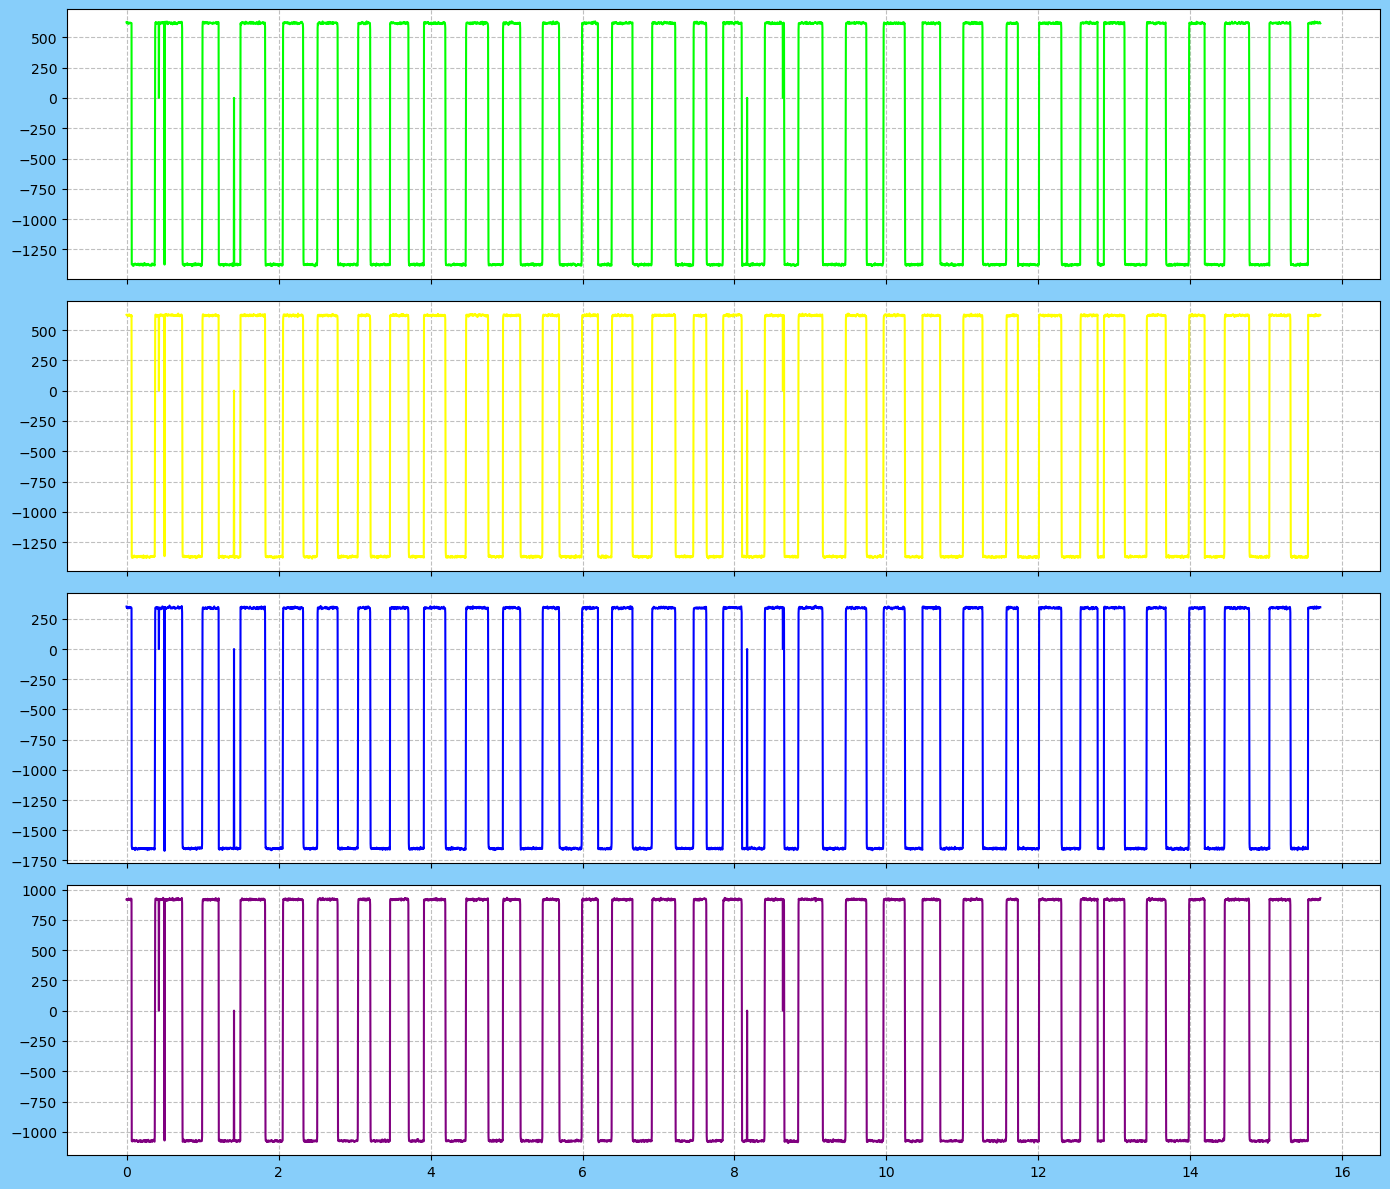

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, num=0, figsize=(14, 12), tight_layout=True, sharex=True)
fig.set_facecolor('lightskyblue')

ax1.plot(t, x1[0], lw=1.5, color=chan_col['T3'])
ax1.grid(alpha=.8, ls='--')
# ax1.set_xlim(t.min(), t.max() + 1/fs)

ax2.plot(t, x1[1], lw=1.5, color=chan_col['T4'])
ax2.grid(alpha=.8, ls='--')

ax3.plot(t, x1[2], lw=1.5, color=chan_col['O1'])
ax3.grid(alpha=.8, ls='--')
# ax3.set_ylim(-40, 40)

ax4.plot(t, x1[3], lw=1.5, color=chan_col['O2'])
ax4.grid(alpha=.8, ls='--')
# ax4.set_ylim(-30, 30)

# ax5.plot(t, x2[0], lw=1.5, color=chan_col['O2'])
# ax5.grid(alpha=.8, ls='--')
# # ax5.set_ylim(-30, 30)

# ax6.plot(t, x2[1], lw=1.5, color=chan_col['O1'])
# ax6.grid(alpha=.8, ls='--')
# # ax6.set_ylim(-40, 40)

# ax7.plot(t, x2[2], lw=1.5, color=chan_col['T4'])
# ax7.grid(alpha=.8, ls='--')

# ax8.plot(t, x2[3], lw=1.5, color=chan_col['T3'])
# ax8.grid(alpha=.8, ls='--')

plt.show()

## FILTERING

In [68]:
fl, fh = 5., 40.
tmn, tmx = 0.5, 30.8

In [69]:
eeg_raw_f_1 = eeg_raw_1.copy().filter(l_freq=fl, h_freq=fh, method='fir', phase='zero-double', fir_window='hamming', 
                                      fir_design='firwin', pad='reflect', verbose=True).crop(tmin=tmn, tmax=tmx, include_tmax=False, verbose=True)
print(eeg_raw_f_1.n_times)
eeg_raw_f_2 = eeg_raw_2.copy().filter(l_freq=0.5, h_freq=fh, method='fir', phase='zero-double', fir_window='hamming', 
                                      fir_design='firwin', pad='reflect', verbose=True).crop(tmin=tmn, tmax=tmx, include_tmax=False, verbose=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 40 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-12 dB cutoff frequency: 45.00 Hz)
- Filter length: 817 samples (1.651 s)

14998
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB 

In [70]:
x1, t1 = eeg_raw_f_1.get_data(return_times=True, units='uV')
x2, t2 = eeg_raw_f_2.get_data(return_times=True, units='uV')
print(x1.shape)
print(x2.shape)

(4, 14998)
(4, 14998)


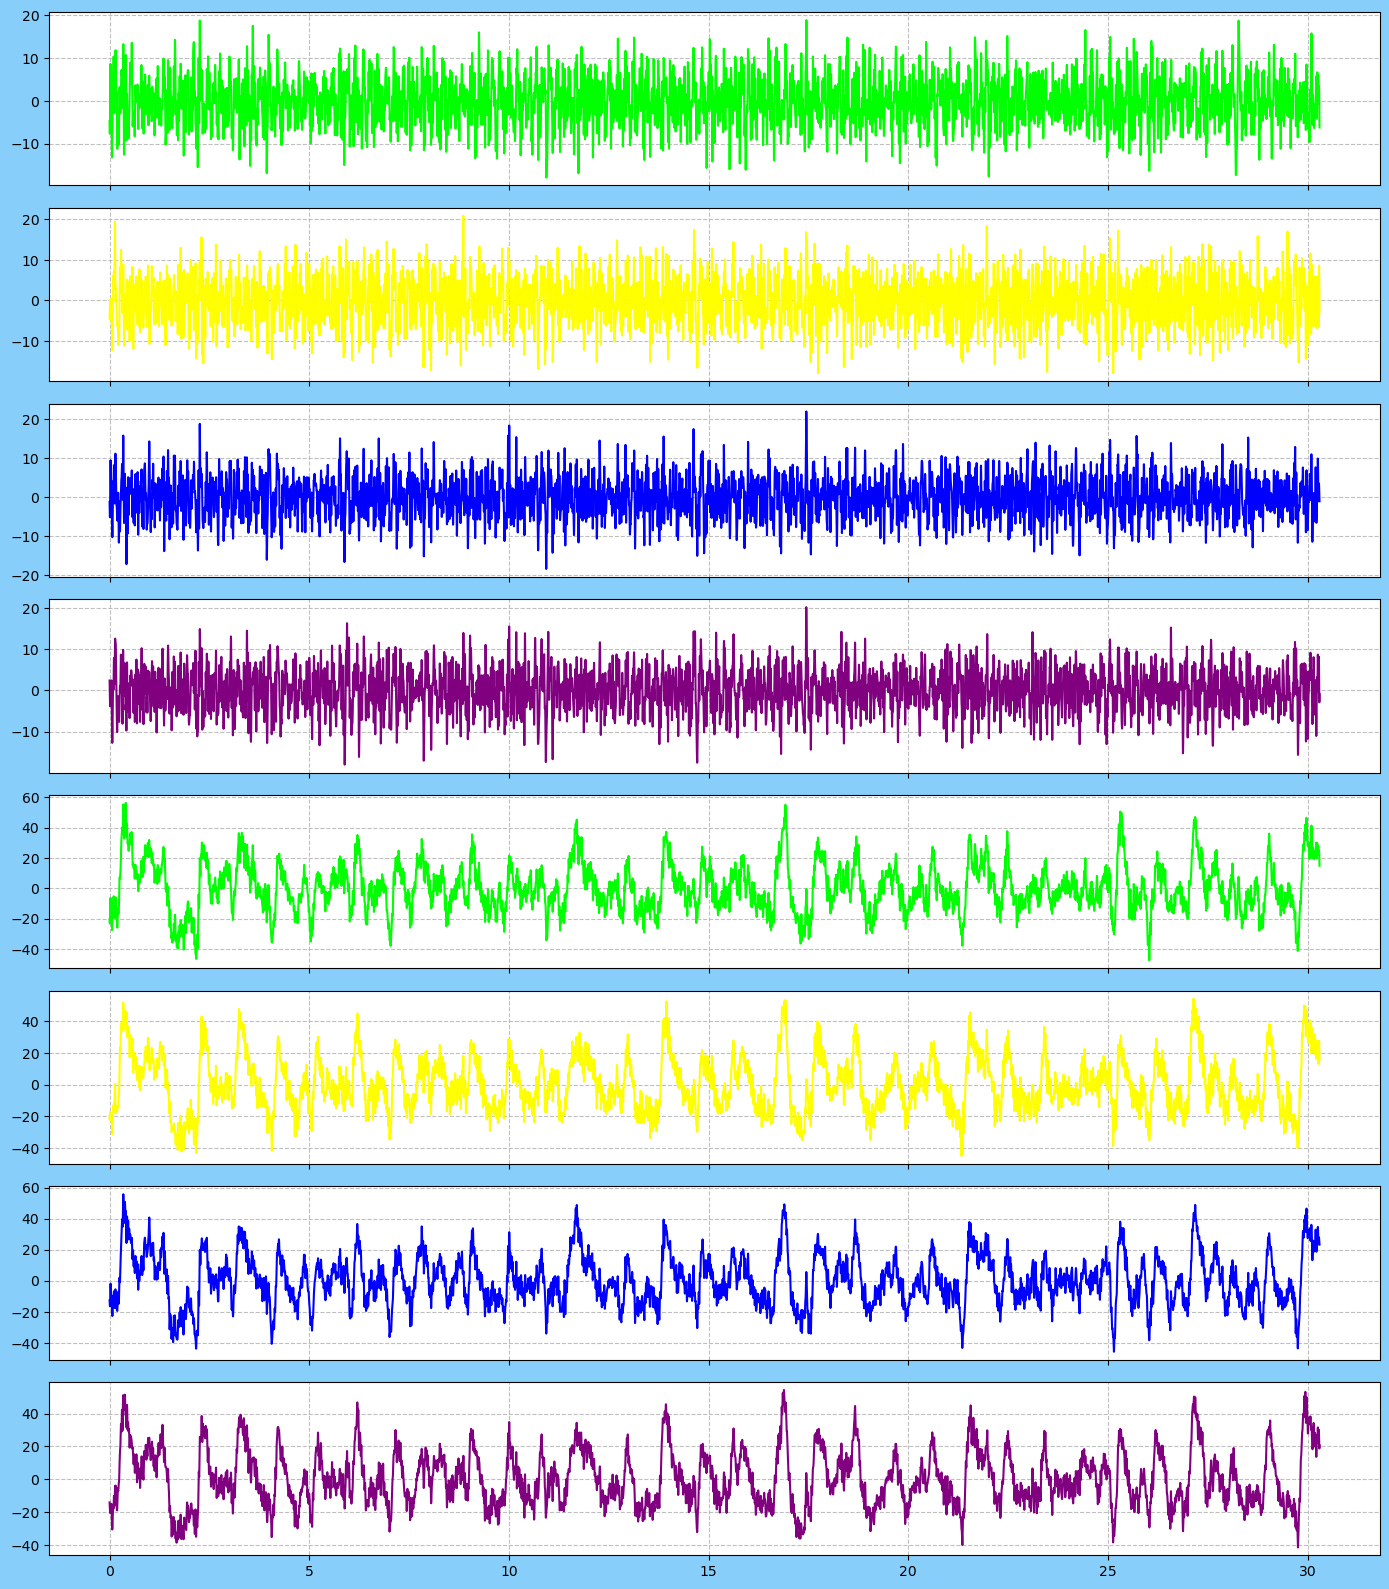

In [71]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(nrows=8, ncols=1, num=0, figsize=(14, 16), tight_layout=True, sharex=True)
fig.set_facecolor('lightskyblue')

ax1.plot(t1, x1[0], lw=1.5, color=chan_col['T3'])
ax1.grid(alpha=.8, ls='--')
# ax1.set_xlim(t.min(), t.max() + 1/fs)

ax2.plot(t1, x1[1], lw=1.5, color=chan_col['T4'])
ax2.grid(alpha=.8, ls='--')

ax3.plot(t1, x1[2], lw=1.5, color=chan_col['O1'])
ax3.grid(alpha=.8, ls='--')
# ax3.set_ylim(-40, 40)

ax4.plot(t1, x1[3], lw=1.5, color=chan_col['O2'])
ax4.grid(alpha=.8, ls='--')
# ax4.set_ylim(-30, 30)

ax5.plot(t2, x2[0], lw=1.5, color=chan_col['T3'])
ax5.grid(alpha=.8, ls='--')
# ax5.set_ylim(-30, 30)

ax6.plot(t2, x2[1], lw=1.5, color=chan_col['T4'])
ax6.grid(alpha=.8, ls='--')
# ax6.set_ylim(-40, 40)

ax7.plot(t2, x2[2], lw=1.5, color=chan_col['O1'])
ax7.grid(alpha=.8, ls='--')

ax8.plot(t2, x2[3], lw=1.5, color=chan_col['O2'])
ax8.grid(alpha=.8, ls='--')

plt.show()

## SPECTRAL ANALYSIS

In [72]:
ventana = 4
win = int(ventana * fs)
eeg_PSD_f_1 = eeg_raw_f_1.compute_psd(method='welch', fmin=0.1, fmax=40.0, picks='data', verbose=True, 
                                      n_fft=win, n_overlap=win // 2, n_per_seg=win, window='hann')
eeg_PSD_f_2 = eeg_raw_f_2.compute_psd(method='welch', fmin=0.1, fmax=40.0, picks='data', verbose=True, 
                                      n_fft=win, n_overlap=win // 2, n_per_seg=win, window='hann')

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


Plotting power spectral density (dB=False).
Plotting power spectral density (dB=False).


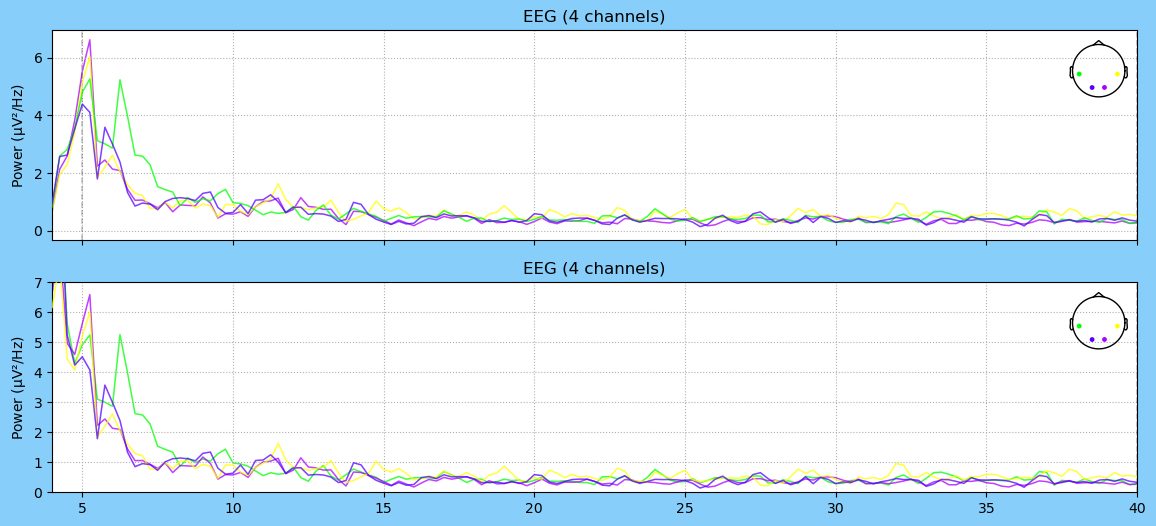

In [77]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, num=0, figsize=(14, 6), sharex=True)
fig.set_facecolor('lightskyblue')

# Graficar la PSD en el Axes personalizado
eeg_PSD_f_1.plot(dB=False, amplitude=False, spatial_colors=True, axes=ax1)
eeg_PSD_f_2.plot(dB=False, amplitude=False, spatial_colors=True, axes=ax2)

# Personalizar el Axes
for line in ax1.get_lines():
    line.set_linewidth(1.1)  # Aumentar el grosor de las líneas
for line in ax2.get_lines():
    line.set_linewidth(1.1)  # Aumentar el grosor de las líneas
# ax1.set_ylim([-5, 25])  # Cambiar los límites del eje y
#
ax2.set_ylim([0, 7])  # Cambiar los límites del eje y
ax1.set_xlim([4, 40])  # Cambiar los límites del eje y

plt.show()

## TIME-FRECUENCY ANALYSIS

In [74]:
interval = int(fs)        # ... the interval size,
overlap = int(fs * 0.95)  # ... and the overlap intervals

                          # Compute the spectrogram
f, t, Sxx = scipy.signal.spectrogram(
    x1,                  # Provide the signal,
    fs=fs,                # ... the sampling frequency,
    window='hann', 
    nperseg=interval,     # ... the length of a segment,
    noverlap=overlap)     # ... the number of samples to overlap,
# Sxx = 10 * np.log10(Sxx)

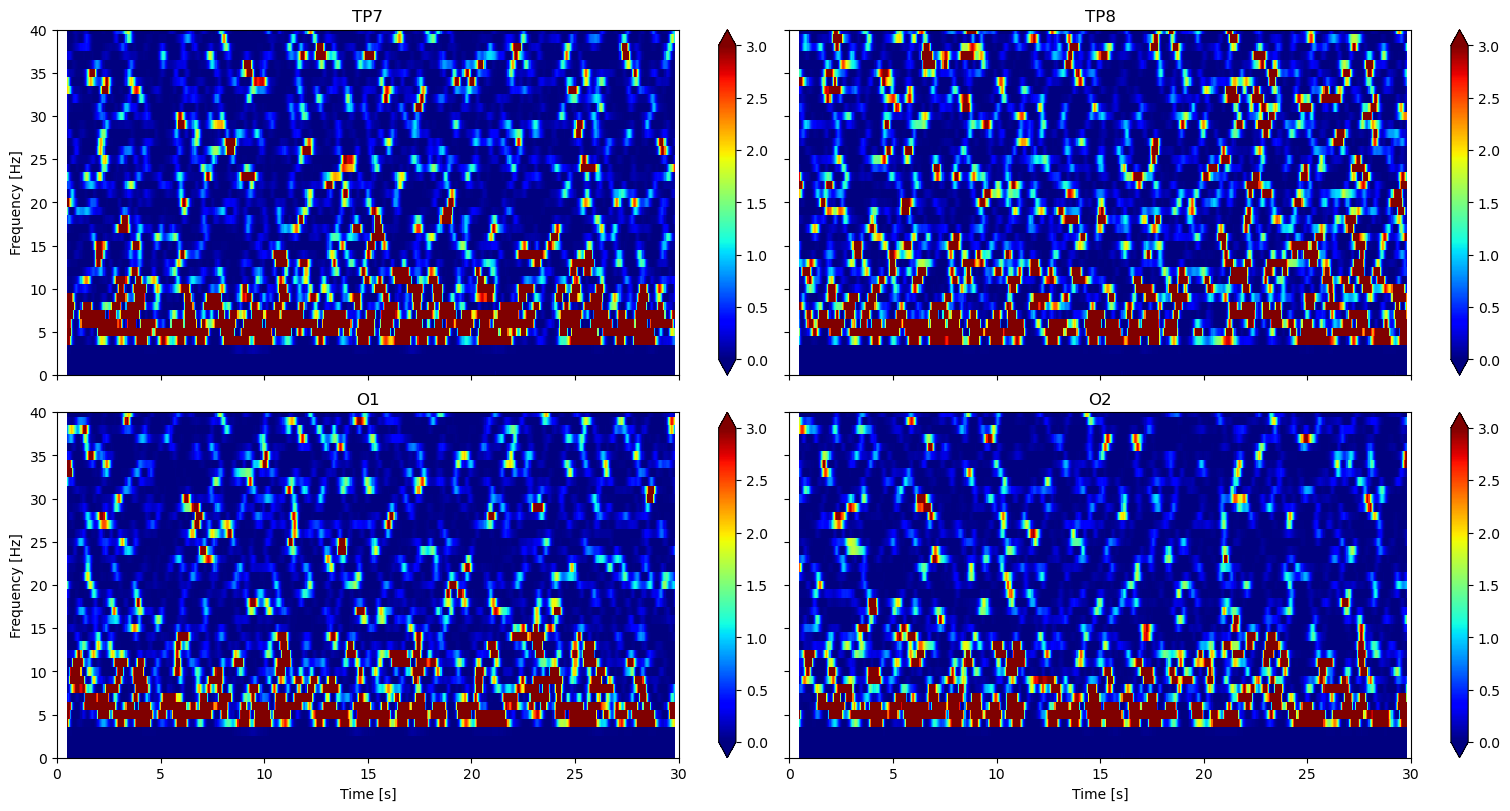

In [78]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8), sharex=True, sharey=True, layout="constrained")

for i in range(2):
    axs[i, 0].set_ylabel('Frequency [Hz]')
    axs[1, i].set_xlabel('Time [s]')        # ... and label the axes
    for j in range(2):
        axs[i, j].set_ylim([0, 40])             # ... set the frequency range,
        axs[i, j].set_xlim([0, 30])             # ... set the frequency range,
        axs[i, j].set_title(channels[j + 2 * i])
        pcm = axs[i, j].pcolormesh(t, f, Sxx[j + 2 * i] ** 2, cmap='jet')
        pcm.set_clim(0, 3)
        fig.colorbar(mappable=pcm, ax=axs[i,j], extend='both')

In [57]:
f, t, Sxx = scipy.signal.spectrogram(
    x2,                  # Provide the signal,
    fs=fs,                # ... the sampling frequency,
    window='hann', 
    nperseg=interval,     # ... the length of a segment,
    noverlap=overlap)     # ... the number of samples to overlap,
Sxx = 10 * np.log10(Sxx)

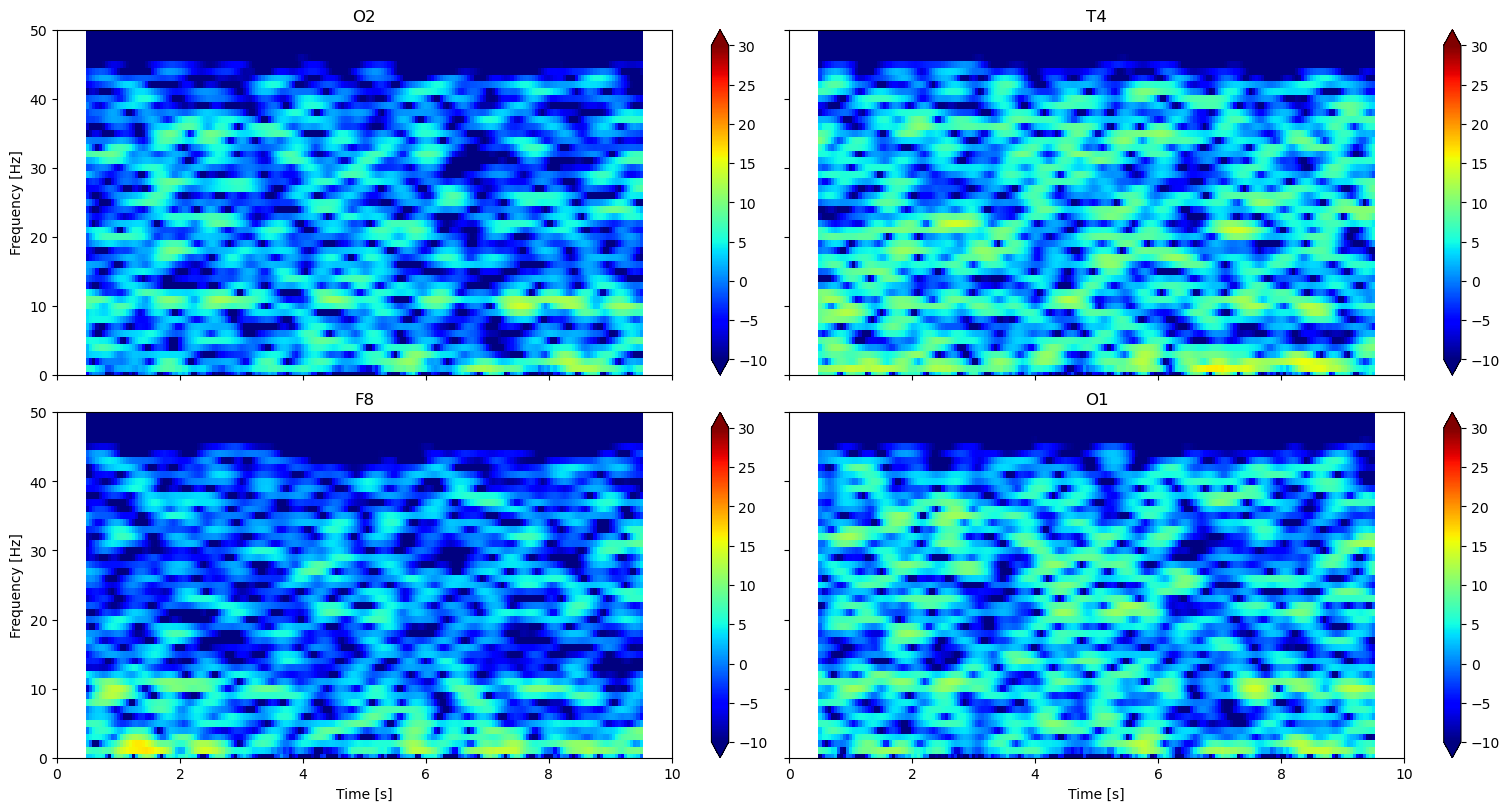

In [63]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8), sharex=True, sharey=True, layout="constrained")

for i in range(2):
    axs[i, 0].set_ylabel('Frequency [Hz]')
    axs[1, i].set_xlabel('Time [s]')        # ... and label the axes
    for j in range(2):
        axs[i, j].set_ylim([0, 50])             # ... set the frequency range,
        axs[i, j].set_xlim([0, 10])             # ... set the frequency range,
        axs[i, j].set_title(channels[j + 2 * i])
        pcm = axs[i, j].pcolormesh(t, f, Sxx[j + 2 * i], cmap='jet')
        pcm.set_clim(-10, 30)
        fig.colorbar(mappable=pcm, ax=axs[i,j], extend='both')

In [20]:
# # Definir parámetros para la TFR
# freqs = np.arange(1, 51, 1)  # Frecuencias de interés
# n_cycles = freqs / 2.  # Número de ciclos por frecuencia
# time_bandwidth = 2.0
# cmap = plt.cm.YlOrBr 

# eeg_TFR_f_2 = eeg_raw_f_2.compute_tfr(method='multitaper', freqs=freqs, picks='data', output='power', verbose=True, 
#                                       n_cycles=n_cycles, time_bandwidth=time_bandwidth)
# print(eeg_TFR_f_2.shape)
# # Visualizar TFR
# fig, axs = plt.subplots(1, 4, figsize=(15, 4), sharey=True, layout="constrained")

# for i, (ax, title) in enumerate(zip(axs, ['Fp2','F8','T4','O2'])):
#     ax.set_title(title)
#     eeg_TFR_f_2.plot([i], baseline=(0, 1), mode='mean', cmap='jet', colorbar=True, title="PERIODOGRAM", axes=ax, show=False)

In [21]:
# eeg_TFR_f_2.plot(baseline=(0,1), mode='logratio', dB=True, cmap=cmap, colorbar=True, title="PERIODOGRAM", show=False)

In [22]:
# freqs

In [23]:
# n_cycles

In [24]:
# n_cycles / freqs

In [25]:
# ventana = 4
# win = int(ventana * fs)
# eeg_PSD_f_1 = eeg_raw_f_1.compute_psd(method='welch', fmax=60.0, picks='data', verbose=True, 
#                                       n_fft=win, n_overlap=win // 2, n_per_seg=win, window='hann')

In [26]:
# interval = int(fs)        # ... the interval size,
# overlap = int(fs * 0.95)  # ... and the overlap intervals

# f, t, Sxx = scipy.signal.spectrogram(
#     x2[1],                  # Provide the signal,
#     fs=fs,                # ... the sampling frequency,
#     window='hann', 
#     nperseg=interval,     # ... the length of a segment,
#     noverlap=overlap)     # ... the number of samples to overlap,

# Sxx = 10 * np.log10(Sxx)

# plt.pcolormesh(t, f, Sxx, cmap='jet')# Plot the result
# plt.colorbar(extend='both')   # ... with a color bar,
# plt.clim(-10, 30);
# plt.ylim([0, 50])             # ... set the frequency range,
# plt.xlim([0, 10])             # ... set the frequency range,
# plt.xlabel('Time [s]')        # ... and label the axes
# plt.ylabel('Frequency [Hz]')

In [27]:
# interval = int(fs)        # ... the interval size,
# overlap = int(fs * 0.95)  # ... and the overlap intervals

#                           # Compute the spectrogram
# f, t, Sxx = scipy.signal.spectrogram(
#     x2[2],                  # Provide the signal,
#     fs=fs,                # ... the sampling frequency,
#     window='hann', 
#     nperseg=interval,     # ... the length of a segment,
#     noverlap=overlap)     # ... the number of samples to overlap,

# Sxx = 10 * np.log10(Sxx)

# plt.pcolormesh(t, f, Sxx, cmap='jet')# Plot the result
# plt.colorbar(extend='both')   # ... with a color bar,
# plt.clim(-10, 30);
# plt.ylim([0, 50])             # ... set the frequency range,
# plt.xlim([0, 10])             # ... set the frequency range,
# plt.xlabel('Time [s]')        # ... and label the axes
# plt.ylabel('Frequency [Hz]')

## ICA

In [195]:
ica = ICA(n_components=4, max_iter="auto", random_state=97)

In [48]:
ica.fit(eeg_raw_f_1)
ica.exclude = [0]
ica.apply(eeg_raw_1)

Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 1 ICA component
    Projecting back using 4 PCA components


<RawArray | 4 x 5500 (11.0 s), ~186 kB, data loaded>

In [196]:
ica.fit(eeg_raw_f_2)
# ica.exclude = [0]
# ica.apply(eeg_raw_2)

Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 78.3s.


c:\Users\ELOY\miniconda3\envs\eeg\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


AttributeError: 'ICA' object has no attribute 'plot'

In [197]:
ica.plot_sources(eeg_raw_2, show_scrollbars=False)

Creating RawArray with float64 data, n_channels=4, n_times=5500
    Range : 0 ... 5499 =      0.000 ...    11.222 secs
Ready.


In [131]:
channel_data = np.empty(8, dtype=int)
for channel in range(0, 8):
    sample = channel
    channel_data[channel] = sample

technologies = {
    'Courses':"Spark",
    'Fee' :24000,
    'Duration':'30day',
    'Discount':channel_data
          }

lista = []
for i in range(10):
    lista.append(technologies)

# Convertir el array de numpy a una lista de Python
for tech in lista:
    tech['Discount'] = [int(i) for i in tech['Discount']]

import json

with open('datos.txt', 'w') as tfile:
    for dic in lista:
        tfile.write(json.dumps(dic) + '\n')